# TODOs
- [X] Metadaten.json zu Python Variablen, in Python Dictionary einspeisen und auslesen (Parkplätze, WiFi) -> Frank
- [X] Map (Slider, Heat Map, Animationen) Visualisierungen -> Frank
- [X] virtual env vorbereiten -> Rich
- [X] projektserver? -> Rich
- [X] Erste Statistiken (Bar Charts, Graphs usw.) Visualisierungen -> Rich
- [ ] Chart Ideen -> Anja
- [ ] Unsere Daten in PowerBI einspeisen, (welche Daten bräuchten wir z.B. für Graph Bubble oder allgemeine Sachen) oder was kostenloses (z.B. CliqSense) -> Anja

# Unsere Quellen zum Visualisierungserfolg:
### Wie Wähle ich die richtige Visualisierung?

https://eazybi.com/blog/data_visualization_and_chart_types/

### Wo finde ich sie in Python?

https://python-graph-gallery.com

# Domänenwissen

* Öffnungszeiten (Theater, Uni)
* Peak Times, Tag
* Ferienzeiten
* Special Events (Demos, Strassensperren)
* Parkplätze kostenlos/bezahlt?
* Sonntag Flohmarkt

# Ideen
* Vergleich mit Wetterdaten
* Verlgeich mit Öffis -> Empfehlungen aussprechen -> z.B. mehr Busse sollen fahren, aber eine U-Bahn kann ausfallen
* Anhand von hauptsächlich Fußgänger könnte man behaupten, wann Vorlesungen auf der TU sind

# Korrelation
* Wie viele fahren rein um bestimmte Uhrzeit rein -> Belegung Parkplätze
* WiFi Nutzung in Zusammenhang mit parkenden Autos?

# Prädiktionen (ML)
* Traffic-/Personenaufkommen zu bestimmten Tageszeiten

# Distribution
* Normalverteilung

# Intervall
* Tageszeiten
* Wochen

# Fragen flow.lab
* Wie wurden Pedestrian Daten aufgenommen?
* Was sind die Daten bei WiFi?
* Gibt es schon Ergebnisse aus Wettbewerb?
* Gibt es neue Daten?
* Erklärung zu Datenset?

## Data für PowerBI

1. Parking:
i. menschlich lesbaren namen geben
ii. TIme in excel format speichern 
    a. wochen (später statistik woche zu woche)
    b. wochentage ( stat wochentag zu denselben ander woche)
    c. tageszeit ( stat pro tag)
    d. Alle Stat über ganze periode, woche, tag
    e. Balkendia mit max-belegung durch tag, woche, ganze periode
    f. haufigkeit der belegung

2. Trafic:
i. Time in excel format speichern
ii. klären was ist overall

3. wifi:
i. no legend - no ststistics

4. pedestrian:
i. Time!
ii. wir können allgemein menschenZahl in bezug zu Zeit analysieren. 
Bsp. 12:00 = 234 am Platz

zu alle : 1 Korellation mit Zeit prüfen
          2 alle Intervalle auf einander legen  - Min Max Median Mittelwert
	  3 Hypotesen: 
		Studis parken
		Flohmarkt parkt
		Stosszeiten ermitteln und gegenbeispiel untersuchen. siehe 2
		Normalverteilt? siehe 2

In [4]:
# get default size onboard
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)
pylab.rcParams['figure.dpi'] = 200

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import folium.plugins as plugins
from IPython.display import HTML
import sklearn as sk
import numpy as np
import datetime
from datetime import timedelta
import json

Populating the interactive namespace from numpy and matplotlib


In [5]:
# Hide Code Function

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

### Erklärungen/Links zu wichtigen Libraries
- Markdown schreiben hier in Jupyter: https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet
- folium für map Visualisierungen: https://github.com/python-visualization/folium

### Daten einlesen
> Erns-Reuter-Platz Datensatz aus http://flow.dai-labor.de

In [6]:
wifi = pd.read_csv('data/wifi.csv')
parking = pd.read_csv('data/parking.csv', delimiter=' ')
# TODO: hier restlichen Datensätze einlesen

### Sinn aus den Daten machen 

In [7]:
# TODO: alle Typen aus der metadata.json in Python Variablen, z.B.:
campus_eb = [52.512388, 13.32360925]
campus_tel = [52.51298775, 13.32029525]
ernst_reuter_platz_center = [52.512611, 13.321856]

# TODO: json daten auslesen
metadata = json.loads(open('data/metadata.json').read())

wifi_latlon = metadata['wifi']['latlon']
pedestrian_latlon = metadata['pedestrian']['latlon']
traffic_latlon = metadata['traffic']['latlon']
parking_latlon = metadata['parking']['latlon']

### Wichtige Libraries
- folium für map Visualisierungen: https://github.com/python-visualization/folium

# Unsere Mission

# Sensoren der Senatsverwaltung im Flow Projekt

![Sensor_Locations](images/Sensor_Locations.jpg)

### Sensoren Visualisierungstool

In [8]:
## TODO: take center of ernst-reuter platz as location=POINT
map = folium.Map(location=ernst_reuter_platz_center, zoom_start=17)


for key in wifi_latlon:
    folium.Circle(
        radius=50,
        location=wifi_latlon[key],
        popup=key,
        color='#3186cc',
        fill=True
    ).add_to(map)
    
for key in pedestrian_latlon:
    folium.Marker(
        location=pedestrian_latlon[key],
        popup=key,
        icon=folium.Icon(icon='info-sign')
    ).add_to(map)
    
for key in traffic_latlon:
    folium.Marker(
        location=traffic_latlon[key],
        popup=key,
        icon=folium.Icon(color='red',icon='info-sign')
    ).add_to(map)

for key in parking_latlon:
    folium.Circle(
        radius=2,
        location=parking_latlon[key],
        popup=key,
        color='red',
        fill=True
    ).add_to(map)

map

### Park Daten

In [9]:
parking['Time'] = pd.to_datetime(parking['Timestamp'], unit='ms')
parking['Weekday'] = parking['Time'].dt.dayofweek
parking['Hour'] = parking['Time'].dt.hour
parking = parking.sort_values(by=['Timestamp'])

def weekday_parking(weekday, fromTime, toTime):
    if weekday != -1:
        day_parking = parking[parking['Weekday'] == weekday]
    else:
        day_parking = parking.copy()
        
    day_parking = day_parking[day_parking['Hour'] >= fromTime]
    day_parking = day_parking[day_parking['Hour'] <= toTime]

    start = float(day_parking[['Timestamp']].iloc[0])
    end = float(day_parking[['Timestamp']].iloc[-1])
    startDayTime = day_parking[['Time']].iloc[0].dt
    endDayTime = day_parking[['Time']].iloc[-1].dt
    
    lastTime = startDayTime
    
    totalDays = 1

    for index, row in day_parking.iterrows():
        if (int(row['Time'].day) != int(lastTime.day)):
            lastTime = row['Time']
            totalDays+=1
            

    totalTime = timedelta(days=totalDays)
    totalTime -= timedelta(hours=int(startDayTime.hour))
    totalTime -= timedelta(hours=(24 - int(endDayTime.hour)))
    totalTime -= timedelta(hours=totalDays*fromTime)
    totalTime -= timedelta(hours=totalDays*(24-toTime))
    
    mean_weekday_parking = {}
    
    for key in parking_latlon:
        temp = day_parking[day_parking['ParkingSpotID'] == key][['Timestamp','Occupied','Time']]
        if len(temp) > 0:
            occupied = temp.iloc[0]['Occupied'] == 1
            lastTime = start
            lastDayTime = startDayTime
            mean_weekday_parking[key] = 0

            for index, row in temp.iterrows():
                ##cut off when the day switches
                if (int(row['Time'].day) != int(lastDayTime.day)):
                    if occupied:
                        ##add time till the end of the day
                        endOfDay = timedelta(hours=(24-int(lastDayTime.hour)))
                        mean_weekday_parking[key] += (endOfDay.total_seconds() * 1000)

                    lastTime = row['Timestamp']
                    lastDayTime = row['Time']
                    occupied = row['Occupied'] == 1
                else:
                    if occupied != (row['Occupied'] == 1):
                        if occupied:
                            mean_weekday_parking[key] += row['Timestamp'] - lastTime
                        else:
                            lastTime = row['Timestamp']
                        occupied = row['Occupied'] == 1

            if occupied:
                mean_weekday_parking[key] += end - lastTime

            mean_weekday_parking[key] /= (totalTime.total_seconds() * 1000)
            
            if mean_weekday_parking[key] > 1:
                mean_weekday_parking[key] = 1
            ##print(key, ":", mean_weekday_parking[key])
    
    return mean_weekday_parking;

In [10]:
def show_parking(data):
    parkplatz_center = [52.513025, 13.319505]
    parking_map = folium.Map(location=parkplatz_center, zoom_start=18)

    for key in parking_latlon:
        if key in data:
            visual = data[key]
            folium.Circle(
                radius=1,
                location=parking_latlon[key],
                popup=key + ": " + str(int(visual*100)) + "%",
                color='#%02x%02x%02x' % (int(255 * (1-visual)),int(255 * (1-visual)), int(255 * (1-visual))),
                fill=True
            ).add_to(parking_map)
    return parking_map;
    
## schwarz = häufig belegt, weiß = weniger häufig belegt
# TODO: Prozente 
show_parking(weekday_parking(-1, 6, 22))

# Traffic

## Pedestrians

In [11]:
df_pedestrians_original = pd.read_csv('data/pedestrian_counts_tel_a.csv', sep=" ")
print('Total number of entries: \n\n' + str(df_pedestrians_original.count()))
print('\n\nExample Output: ')
df_pedestrians_original.head()

Total number of entries: 

StationIdentifier    402616
Timestamp            402616
Direction            402616
Count                402616
dtype: int64


Example Output: 


,StationIdentifier,Timestamp,Direction,Count
0,CounterVorplatzGeb-AF2-PeopleCounter,1515525300416,IN,0
1,CounterVorplatzGeb-AF2-PeopleCounter,1515525300418,OUT,0
2,CounterHaupteingang-TEL4-PeopleCounter,1515525300417,IN,0
3,CounterHaupteingang-TEL4-PeopleCounter,1515525300415,OUT,0
4,CounterVorplatzGeb-AF2-PeopleCounter,1515525360372,IN,0


### Clean

In [12]:
# clone for backup
df_pedestrians = df_pedestrians_original
# rename
df_pedestrians = df_pedestrians.replace({'CounterVorplatzGeb-AF2-PeopleCounter':'af_counter', 'CounterHaupteingang-TEL4-PeopleCounter':'telekom_counter'})
# drop zero counts
df_pedestrians = df_pedestrians[df_pedestrians.Count != 0]
# timestamp to python data type
df_pedestrians['Timestamp'] = pd.to_datetime(df_pedestrians['Timestamp'].astype(int), unit='ms')

### Verify Dataset Integrity

In [13]:
df_pedestrians_IN = df_pedestrians[df_pedestrians['Direction'] == 'IN'] 
df_pedestrians_OUT = df_pedestrians[df_pedestrians['Direction'] == 'OUT']

In [14]:
df_pedestrians_IN_af = df_pedestrians_IN[df_pedestrians_IN['StationIdentifier'] == 'af_counter']
df_pedestrians_OUT_af = df_pedestrians_OUT[df_pedestrians_OUT['StationIdentifier'] == 'af_counter']
df_pedestrians_IN_tel = df_pedestrians_IN[df_pedestrians_IN['StationIdentifier'] == 'telekom_counter']
df_pedestrians_OUT_tel = df_pedestrians_OUT[df_pedestrians_OUT['StationIdentifier'] == 'telekom_counter']

count_total_IN_records = df_pedestrians_IN['Count'].count()
count_total_OUT_records = df_pedestrians_OUT['Count'].count()
count_walked_IN_af = df_pedestrians_IN_af.Count.sum()
count_walked_OUT_af = df_pedestrians_OUT_af.Count.sum()
count_walked_IN_tel = df_pedestrians_IN_tel.Count.sum()
count_walked_OUT_tel = df_pedestrians_OUT_tel.Count.sum()

### Fußgänger

![map_overview](images/sensor_overview_openstreet_map.png)

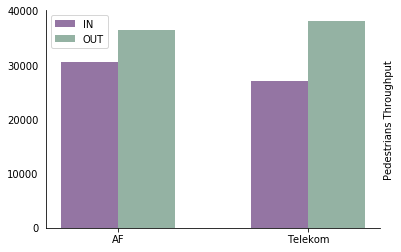

The buildings must be spawning pedestrians from the cellar 😱🧙
Or there might be different entries to the building...


In [15]:
# as bar chart
bar_width = 0.3
bars1 = [count_walked_IN_af, count_walked_IN_tel]
bars2 = [count_walked_OUT_af, count_walked_OUT_tel]
# x position of bars
r1 = np.arange(len(bars1))
r2 = [x + bar_width for x in r1]
# create bars1
plt.bar(r1, bars1, width=bar_width, color=(0.3,0.1,0.4,0.6), capsize=7, label='IN')
plt.bar(r2, bars2, width=bar_width, color=(0.3,0.5,0.4,0.6), capsize=7, label='OUT')

# general layout
plt.xticks([0.15, 1.15], ['AF', 'Telekom'])
plt.ylabel('Pedestrians Throughput')
plt.gca().yaxis.set_label_position("right")
plt.locator_params(axis='y', nbins=5)
plt.legend()
plt.tick_params(top=False, bottom=True, left=False, right=False, labelleft=True, labelbottom=True)
# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Show graphic
plt.show()
print('The buildings must be spawning pedestrians from the cellar 😱🧙')
print('Or there might be different entries to the building...')

In [16]:
times = pd.DatetimeIndex(df_pedestrians.Timestamp)
grouped = df_pedestrians.groupby([times.hour])
grouped_direction_count = grouped['Direction'].count()
grouped_direction_count.get('Direction')

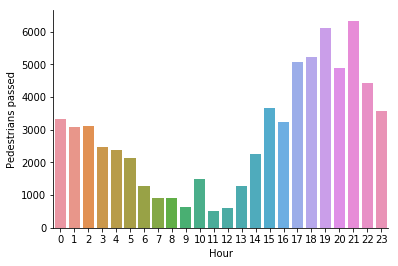

In [17]:
hist_in_out_pedestrians = sns.barplot(x=grouped_direction_count.index, y=grouped_direction_count.values)
hist_in_out_pedestrians.set(xlabel='Hour', ylabel='Pedestrians passed')
sns.distplot
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()

## WIFI Connections

In [18]:
df_wifi_original = pd.read_csv('data/wifi.csv', sep=" ")
df_wifi = df_wifi_original
df_wifi['Timestamp'] = pd.to_datetime(df_wifi['Timestamp'].astype(int), unit='ms')

wifi_times = df_wifi['Timestamp']
wifi_grouped_sum = df_wifi.groupby([wifi_times.dt.hour]).sum()

wifi_grouped_sum.head()

,DevicesTracked,ApproxVerweildauerSek
Timestamp,,
0,42173,25766.0
1,43498,21067.0
2,46610,18299.0
3,49385,24152.0
4,56334,23158.0


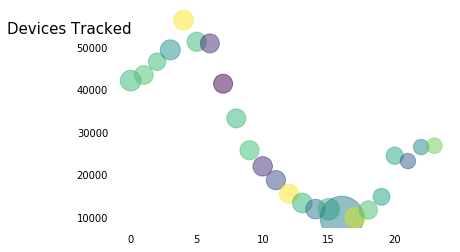

In [19]:
np.random.seed(19680801)
x = wifi_grouped_sum.index
y = wifi_grouped_sum['DevicesTracked']
bubble_area = (wifi_grouped_sum['ApproxVerweildauerSek'] / 60)
colors = np.random.rand(24)

wifi_scatter = plt.scatter(x, y, s=bubble_area, c=colors, alpha=0.5)
# general layout
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=True, labelbottom=True)
# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
# put some text
plt.text(0.05,0.95, 'Devices Tracked', fontsize="15", ha="right", va="top", transform=plt.gca().transAxes)
# supress pyplot output
_ = plt.show